In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler
from collections import Counter

In [2]:
train = pd.read_csv("fraud_train.csv", na_values=[], keep_default_na=False)
test = pd.read_csv("fraud_test.csv", na_values=[], keep_default_na=False)

In [3]:
train.head()


,Unnamed: 0,fraud_bool,income,name_email_similarity,prev_address_months_count,current_address_months_count,customer_age,days_since_request,intended_balcon_amount,payment_type,...,bank_months_count,has_other_cards,proposed_credit_limit,foreign_request,source,session_length_in_minutes,device_os,keep_alive_session,device_distinct_emails_8w,month
0,409919,0,0.5,0.533645,-1,47,20,0.010426,-0.775947,AC,...,-1,0,1500.0,0,INTERNET,30.650408,other,0,1,3
1,679596,0,0.6,0.762213,198,8,20,0.020051,10.628024,AA,...,28,0,500.0,0,INTERNET,2.045171,other,1,1,5
2,579377,0,0.9,0.386071,60,12,20,7.009744,51.695466,AA,...,29,0,1000.0,0,INTERNET,11.071376,linux,1,1,4
3,851406,0,0.6,0.311304,-1,221,40,0.012369,-1.236389,AB,...,11,0,1500.0,0,INTERNET,10.796589,linux,1,1,6
4,519975,0,0.1,0.824045,86,6,20,0.039485,-0.659062,AC,...,-1,0,200.0,0,INTERNET,6.790446,linux,1,1,3


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 32 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Unnamed: 0                        100000 non-null  int64  
 1   fraud_bool                        100000 non-null  int64  
 2   income                            100000 non-null  float64
 3   name_email_similarity             100000 non-null  float64
 4   prev_address_months_count         100000 non-null  int64  
 5   current_address_months_count      100000 non-null  int64  
 6   customer_age                      100000 non-null  int64  
 7   days_since_request                100000 non-null  float64
 8   intended_balcon_amount            100000 non-null  float64
 9   payment_type                      100000 non-null  object 
 10  zip_count_4w                      100000 non-null  int64  
 11  velocity_6h                       100000 non-null  fl

In [5]:
train['fraud_bool'].value_counts()

,count
fraud_bool,
0,98941
1,1059


In [6]:
train['fraud_bool'].value_counts(normalize=True)

,proportion
fraud_bool,
0,0.98941
1,0.01059


## חלוקה

In [7]:
# חודשים 0–6 -> אימון
# חודשים 6–12 -> ולידציה
train_df = train[train["month"] <= 6].copy()
val_df = train[train["month"] > 6].copy()

In [8]:
def preprocess(df, target_col="fraud_bool"):
    df = df.copy()

    # מפרידים תכונות ומטרה
    X = df.drop(columns=[target_col])
    y = df[target_col]

    # זיהוי עמודות
    num_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
    cat_cols = X.select_dtypes(include=["object", "category"]).columns.tolist()

    # יצירת טרנספורמר לעיבוד העמודות
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", StandardScaler(), num_cols),
            ("cat", OneHotEncoder(drop="first", sparse_output=False), cat_cols)
        ]
    )

    # עיבוד X בעזרת הטרנספורמר
    X_processed = preprocessor.fit_transform(X)

    # שמירת שמות העמודות החדשים (לא חובה, אבל שימושי אם רוצים לשמור על מידע)
    num_features = num_cols
    cat_features = preprocessor.named_transformers_["cat"].get_feature_names_out(cat_cols)
    feature_names = num_features + cat_features.tolist()

    # החזרת DataFrame מעובד
    X_processed = pd.DataFrame(X_processed, columns=feature_names, index=X.index)

    return X_processed, y


In [9]:
# עיבוד קבוצות
X_train, y_train = preprocess(train_df)
X_val, y_val = preprocess(val_df)

# התאמת העמודות בין הקבוצות
X_val = X_val.reindex(columns=X_train.columns, fill_value=0)

In [10]:
def evaluate_model(model, X_test, y_test, title):
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]
    print(f"\n--- {title} ---")
    print(classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()
    print("ROC-AUC:", roc_auc_score(y_test, y_scores))
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    plt.plot(fpr, tpr)
    plt.title(f"ROC Curve - {title}")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.show()

## המודל הבסיסי


--- Random Forest ---
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      9624
           1       0.00      0.00      0.00       140

    accuracy                           0.99      9764
   macro avg       0.49      0.50      0.50      9764
weighted avg       0.97      0.99      0.98      9764



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


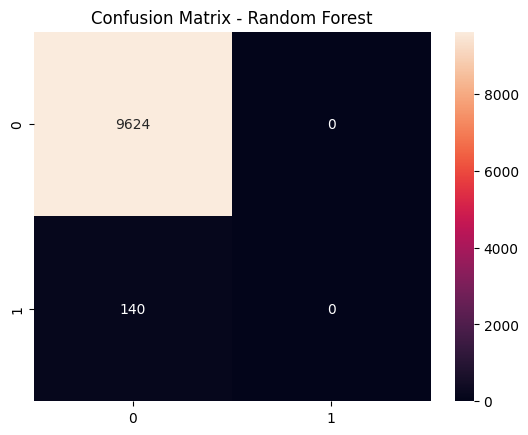

ROC-AUC: 0.7751406454102838


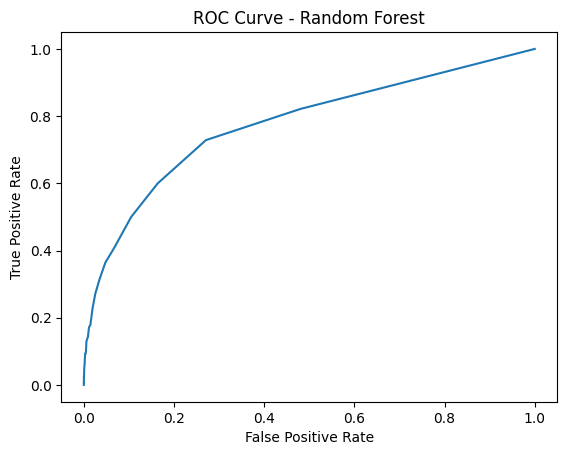

In [11]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)
evaluate_model(clf, X_val,y_val, "Random Forest")

## סמוט לאיזון נתונים

In [12]:
smote = SMOTE(random_state=42)

# החלת SMOTE על קבוצת האימון – מאזנת את המחלקות
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

print("Combined Sampling:", Counter(y_resampled))

Combined Sampling: Counter({0: 89317, 1: 89317})


## היפר פרמטר

In [ ]:
# הגדרת פרמטרים לרשת החיפוש
param_grid = {
    'n_estimators': [20, 50, 100, 150],
    'max_depth': [0, 10, 20, 30]
}

# יצירת המודל הבסיסי
rf_model = RandomForestClassifier(random_state=42)

# הגדרת GridSearchCV עם קרוס-ולידציה וסקורינג של ROC AUC
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=4,
    n_jobs=-1
)

# התאמה לנתונים שעברו SMOTE
grid_search.fit(X_resampled, y_resampled)

# הערכת המודל הטוב ביותר על קבוצת הוולידציה
best_rf = grid_search.best_estimator_
evaluate_model(best_rf, X_val, y_val, "SMOTE, Random Forest")

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
16 fits failed out of a total of 64.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
16 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/utils/_


--- SMOTE, Random Forest ---
              precision    recall  f1-score   support

           0       0.99      0.78      0.87      9624
           1       0.02      0.37      0.05       140

    accuracy                           0.78      9764
   macro avg       0.51      0.58      0.46      9764
weighted avg       0.97      0.78      0.86      9764



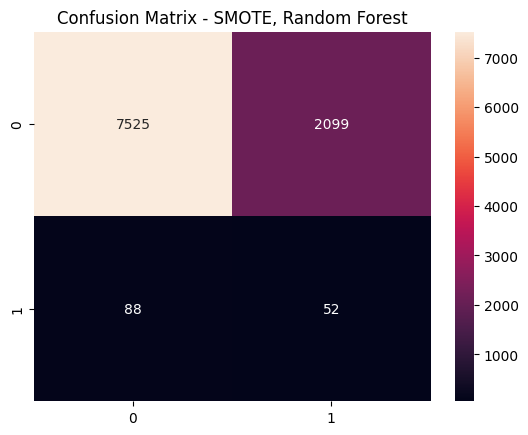

ROC-AUC: 0.5666061780073626


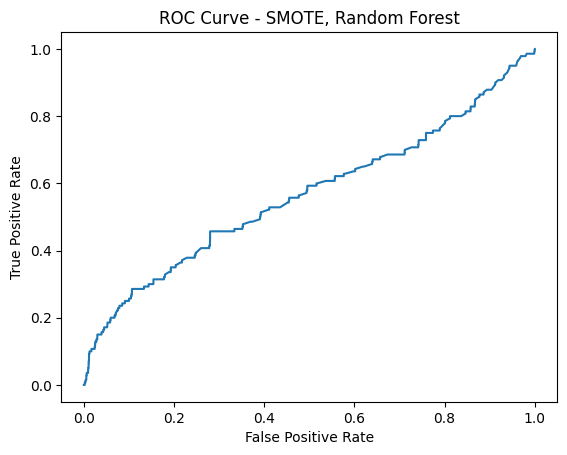

In [13]:
rf_params = {'n_estimators': [20, 50, 100, 150], 'max_depth': [0, 10, 20, 30]}
gs_rf = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, scoring='roc_auc', cv=4, n_jobs=-1)
gs_rf.fit(X_resampled, y_resampled)
evaluate_model(gs_rf.best_estimator_, X_val, y_val, "SMOTE,Random Forest")


## אימון מודל כל אימון ובדיקת חיזוי על המבחן


--- Final Model on Test ---
              precision    recall  f1-score   support

           0       0.99      0.97      0.98     49471
           1       0.11      0.36      0.16       529

    accuracy                           0.96     50000
   macro avg       0.55      0.66      0.57     50000
weighted avg       0.98      0.96      0.97     50000



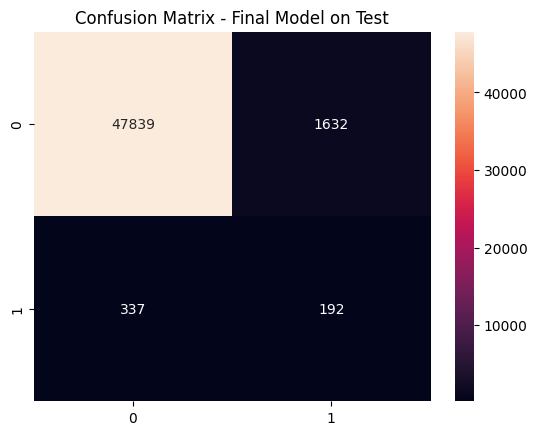

ROC-AUC: 0.8020813897233106


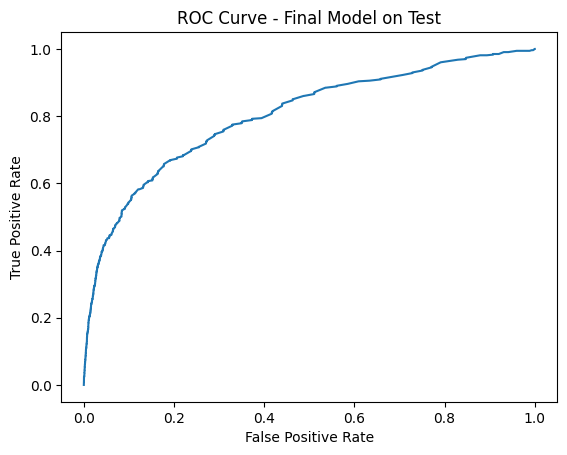

In [15]:
# 1. טעינת כל סט האימון
full_train_df = pd.read_csv("fraud_train.csv")

# 2. עיבוד מקדים
full_X, full_y = preprocess(full_train_df)

# 3. SMOTE על כל סט האימון
smote = SMOTE(random_state=42)
X_resampled_all, y_resampled_all = smote.fit_resample(full_X, full_y)

# 4. אימון מודל סופי עם ההיפר־פרמטרים שנבחרו
final_model = RandomForestClassifier(
    random_state=42,
    class_weight='balanced',
    **grid_search.best_params_  # נלקח מ-GridSearch קודם
)
final_model.fit(X_resampled_all, y_resampled_all)

# 5. טעינת סט הטסט ועיבוד
test_df = pd.read_csv("fraud_test.csv")
test_X, test_y = preprocess(test_df)
test_X = test_X.reindex(columns=X_resampled_all.columns, fill_value=0)

# 6. הערכה סופית – על קבוצת הטסט בלבד
evaluate_model(final_model, test_X, test_y, "Final Model on Test")

## למה בחרתי במודל
# Random forest
 1. מודל זה הינו מודל אשר יודע לזהות תבניות שאינן ליניאריות ובעיות הונאה אינן לינראיות
 2. מתמודד טוב עם חוסר איזון ע"י class_weight='balanced
 3. עמידות לרעש ולמאפיינים לא רלוונטיים - לא מייחס חשיבות למקרי קיצון
 4. מתאים לדאטה עם גם מאפיינים קטגוריים וגם מספריים
 שימוש ב SMOT גורם לפחות בעיות איזון לפתרון class imbalance
 במודל הראשוני ישנו אחוז דיוק גבוה של כמעט 100 אחוז אך אין דיוק במציאת הונאה
 לאחר שימוש המפחית את בעיית האיזון הגענו ל - 36% בזיהוי הונאה
 בנוסף אנו רואים 11% ב - precision דבר המעיד על לא מעט קבלות של התראות שווא
